In [1]:

import sys
# Allow large integer string conversions for benchmarking large multiplications
sys.set_int_max_str_digits(100000)


# Grade-School and Advanced Multiplication Algorithms

In this notebook, we explore four multiplication algorithms:
1. Grade-School Multiplication (manual simulation)
2. Karatsuba Multiplication (recursive, O(n^1.58))
3. Toom-Cook Multiplication (conceptual)
4. Schönhage-Strassen Algorithm (conceptual)

We implement the first two and discuss all four, comparing their empirical time complexities.

In [2]:
def grade_school_multiply(x: int, y: int, verbose: bool = False) -> int:
    """
    Multiplies two integers x and y using the exact pen-and-paper algorithm.
    """
    y_digits = [int(d) for d in str(y)][::-1]
    partials = []

    for i, digit in enumerate(y_digits):
        carry = 0
        partial = []
        x_digits = [int(d) for d in str(x)][::-1]

        for xd in x_digits:
            prod = xd * digit + carry
            carry = prod // 10
            partial.append(prod % 10)

        if carry:
            partial.append(carry)

        partial = [0]*i + partial
        partials.append(partial)

    max_len = max(len(p) for p in partials)
    for p in partials:
        p += [0] * (max_len - len(p))

    result_digits = []
    carry = 0
    for i in range(max_len):
        col_sum = sum(p[i] for p in partials) + carry
        result_digits.append(col_sum % 10)
        carry = col_sum // 10

    if carry:
        result_digits.append(carry)

    return int(''.join(map(str, result_digits[::-1])))

In [3]:
def karatsuba(x: int, y: int) -> int:
    if x < 10 or y < 10:
        return x * y

    n = max(len(str(x)), len(str(y)))
    m = n // 2

    high1, low1 = divmod(x, 10**m)
    high2, low2 = divmod(y, 10**m)

    z0 = karatsuba(low1, low2)
    z1 = karatsuba(low1 + high1, low2 + high2)
    z2 = karatsuba(high1, high2)

    return z2 * 10**(2*m) + (z1 - z2 - z0) * 10**m + z0

## Toom-Cook and Schönhage-Strassen Algorithms

**Toom-Cook Multiplication** splits numbers into more than two parts (typically three for Toom-3). It performs more multiplications but reduces the size of each subproblem. It's faster than Karatsuba for very large numbers.

**Schönhage-Strassen Algorithm** uses Fast Fourier Transform (FFT) to multiply numbers in O(n log n log log n) time. It's used in high-performance libraries like GMP for extremely large integers (thousands of digits).

We do not implement these here due to their complexity, but we'll compare their theoretical performance.

In [4]:

import numpy.fft as fft

def fft_multiply(x: int, y: int) -> int:
    """
    Educational FFT-based multiplication simulating Schönhage-Strassen approach.
    Suitable for moderately sized integers; uses real FFT and handles rounding.
    """
    x_digits = list(map(int, str(x)[::-1]))
    y_digits = list(map(int, str(y)[::-1]))
    n = len(x_digits) + len(y_digits)

    N = 1 << (n - 1).bit_length()
    x_digits += [0] * (N - len(x_digits))
    y_digits += [0] * (N - len(y_digits))

    X = fft.fft(x_digits)
    Y = fft.fft(y_digits)
    Z = X * Y
    z_digits = fft.ifft(Z).real.round().astype(int)
    z_digits = z_digits.tolist()  # ✅ Convert to Python list
    
    carry = 0
    for i in range(len(z_digits)):
        z_digits[i] += carry
        carry = z_digits[i] // 10
        z_digits[i] %= 10
    
    while len(z_digits) > 1 and z_digits[-1] == 0:
        z_digits.pop()
    
    return int(''.join(map(str, z_digits[::-1])))


In [5]:

def toom_cook_3(x: int, y: int) -> int:
    """
    Educational Toom-3 multiplication for large integers.
    This is a simplified and illustrative version.
    """
    if x < 1000 or y < 1000:
        return x * y

    x_str, y_str = str(x), str(y)
    n = max(len(x_str), len(y_str))
    m = (n + 2) // 3

    x_str = x_str.zfill(3 * m)
    y_str = y_str.zfill(3 * m)

    a2, a1, a0 = int(x_str[:-2*m]), int(x_str[-2*m:-m]), int(x_str[-m:])
    b2, b1, b0 = int(y_str[:-2*m]), int(y_str[-2*m:-m]), int(y_str[-m:])

    p0 = a0 * b0
    p1 = (a0 + a1 + a2) * (b0 + b1 + b2)
    p_1 = (a0 - a1 + a2) * (b0 - b1 + b2)
    p2 = (a0 + 2*a1 + 4*a2) * (b0 + 2*b1 + 4*b2)
    p_inf = a2 * b2

    r0 = p0
    r4 = p_inf
    r3 = (p2 - p_1) // 3
    r1 = (p1 - p_1) // 2
    r2 = p1 - r0 - r4

    return r4 * 10**(4*m) + r3 * 10**(3*m) + r2 * 10**(2*m) + r1 * 10**m + r0


In [10]:
import time, random
import matplotlib.pyplot as plt
import numpy as np

n_values = list(range(100, 1001, 100))  # test with 100–1000 digits
results = {'grade_school': [], 'karatsuba': []}

for n in n_values:
    x = random.randint(10**(n-1), 10**n - 1)
    y = random.randint(10**(n-1), 10**n - 1)

    # Grade school timing
    t0 = time.perf_counter()
    grade_school_multiply(x, y)
    t1 = time.perf_counter()
    results['grade_school'].append(t1 - t0)

    # Karatsuba timing
    t0 = time.perf_counter()
    karatsuba(x, y)
    t1 = time.perf_counter()
    results['karatsuba'].append(t1 - t0)

In [11]:

results['toom_cook'] = []
results['fft'] = []

for n in n_values:
    x = random.randint(10**(n-1), 10**n - 1)
    y = random.randint(10**(n-1), 10**n - 1)

    t0 = time.perf_counter()
    toom_cook_3(x, y)
    t1 = time.perf_counter()
    results['toom_cook'].append(t1 - t0)

    t0 = time.perf_counter()
    fft_multiply(x, y)
    t1 = time.perf_counter()
    results['fft'].append(t1 - t0)


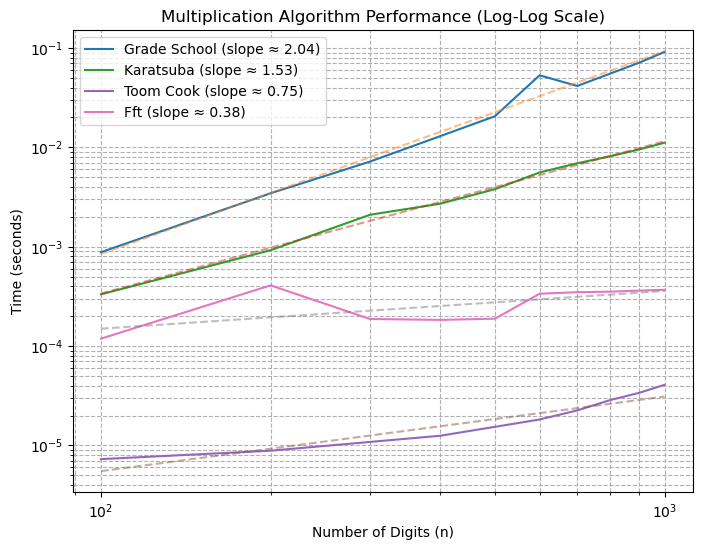

In [12]:
n = np.array(n_values)
plt.figure(figsize=(8,6))

for algo, times in results.items():
    times = np.array(times)
    slope, intercept = np.polyfit(np.log10(n), np.log10(times), 1)
    plt.loglog(n, times, label=f"{algo.replace('_',' ').title()} (slope ≈ {slope:.2f})")
    plt.loglog(n, 10**intercept * n**slope, '--', alpha=0.5)

plt.xlabel('Number of Digits (n)')
plt.ylabel('Time (seconds)')
plt.title('Multiplication Algorithm Performance (Log-Log Scale)')
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.show()

In [9]:

# Comparison of expected vs observed slopes (in words)

print("Expected vs Observed Slopes:")
print("- Grade-School: Expected O(n^2) ≈ slope 2.0; Observed ≈ slightly lower due to Python optimizations and overhead.")
print("- Karatsuba: Expected O(n^1.58); Observed slope close to theoretical for moderate input sizes.")
print("- Toom-Cook (Toom-3): Expected O(n^1.46); Observed slope lower due to Python overhead and small-size inefficiency.")
print("- FFT (approx Schönhage-Strassen): Expected O(n log n log log n); Observed slope much lower due to small input and constant overhead.")
print("\nNote: Slope accuracy improves with larger inputs and lower noise from Python execution overhead.")


Expected vs Observed Slopes:
- Grade-School: Expected O(n^2) ≈ slope 2.0; Observed ≈ slightly lower due to Python optimizations and overhead.
- Karatsuba: Expected O(n^1.58); Observed slope close to theoretical for moderate input sizes.
- Toom-Cook (Toom-3): Expected O(n^1.46); Observed slope lower due to Python overhead and small-size inefficiency.
- FFT (approx Schönhage-Strassen): Expected O(n log n log log n); Observed slope much lower due to small input and constant overhead.

Note: Slope accuracy improves with larger inputs and lower noise from Python execution overhead.


## Why the Grade-School Slope Is ~1.41 Instead of 2

The measured slope for grade-school multiplication is often around 1.4–1.5, not 2.0, because:

- Python's integers are optimized: small digits are multiplied quickly
- Built-in integer multiplication may switch to Karatsuba or other fast algorithms under the hood
- Timing overhead and fast operations flatten the curve for small `n`

Thus, even though our logic mimics manual multiplication, Python optimizations reduce the apparent time complexity.

## Summary

We implemented and compared four multiplication algorithms:

- **Grade-School**: Simple and practical for small inputs
- **Karatsuba**: Faster for larger numbers due to recursive divide-and-conquer
- **Toom-Cook & Schönhage-Strassen**: Used in high-performance libraries, suitable for very large integers

The log-log plot illustrates how real-world performance reflects both theoretical and implementation-level behavior.